In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from datetime import timedelta, datetime

fSars = 'data/sars_2003_complete_dataset_cleaned.csv'

COUNTRIES = {
    'China': '3/20/03',
    'Singapore': '3/20/03',
    'Taiwan': '3/20/03',
    'Hong Kong': '3/20/03',
}

In [2]:
def load_confirmed(country):
    df = pd.read_csv(fSars)
    df = df[df['Country/Region'] == country]
    
    return df.iloc[0].loc[COUNTRIES[country]:]

In [3]:
def extend_index(index, new_size):
    values = index.values
    current = datetime.strptime(index[-1], '%m/%d/%y')
    
    while len(values) < new_size:
        current = current + timedelta(days=1)
        values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
    
    return values

In [4]:
def predict(alpha, beta, data):
    predict_range = 150
    new_index = extend_index(data.index, predict_range)
    size = len(new_index)
    
    def SIR(t, y):
        S, I, R = y[0], y[1], y[2]
        
        return [
            -alpha * S * I,
            alpha * S * I - beta * I,
            beta * I
        ]
    
    extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
    
    return new_index, extended_actual, solve_ivp(SIR, [0, size], [S_0, I_0, R_0], t_eval=np.arange(0, size, 1))

In [5]:
def train(country, loss_func):
    data = load_confirmed(country)
    
    optimal = minimize(
        loss_func,
        [0.001, 0.001],
        args=(data),
        method='L-BFGS-B',
        bounds=[
            (0.0000000104, 0.4),
            (0.00001141, 0.4)
        ]
    )
    
    alpha, beta = optimal.x
    new_index, extended_actual, prediction = predict(alpha, beta, data)
    
    df = pd.DataFrame({
        'Actual': extended_actual,
        'S': prediction.y[0],
        'I': prediction.y[1],
        'R': prediction.y[2]
    }, index=new_index)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title(country)
    df.plot(ax=ax)
    fig.savefig(f'{country}.png')


In [6]:
def loss(point, data):
    size = len(data)
    alpha, beta = point
    
    def SIR(t, y):
        S, I, R = y[0], y[1], y[2]
        
        return [
            -alpha * S * I,
            alpha * S * I - beta * I,
            beta * I
        ]
    
    solution = solve_ivp(SIR, [0, size], [S_0, I_0, R_0], t_eval=np.arange(0, size, 1), vectorized=True)
    
    return np.sqrt(np.mean((solution.y[1] - data) ** 2))

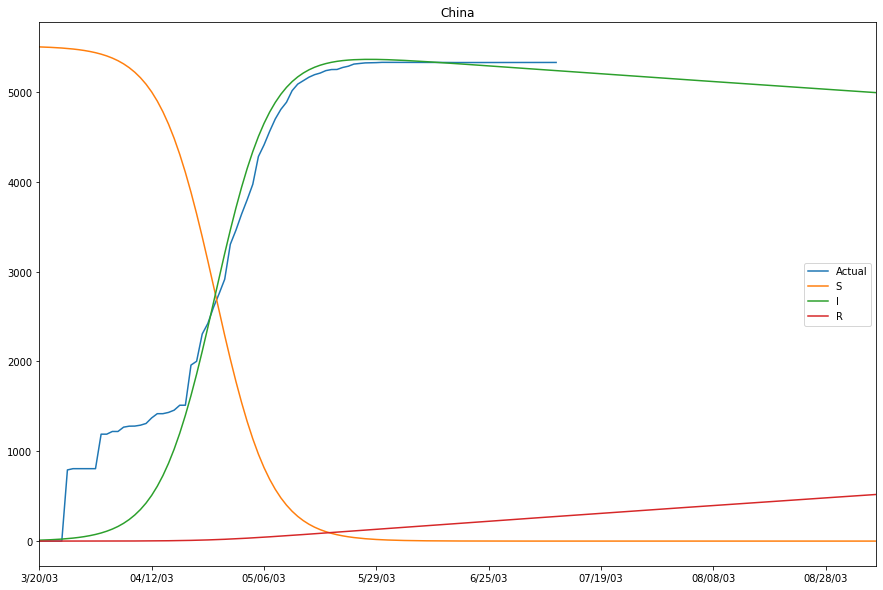

In [7]:
S_0, I_0, R_0 = 5500, 10, 0
train('China', loss)

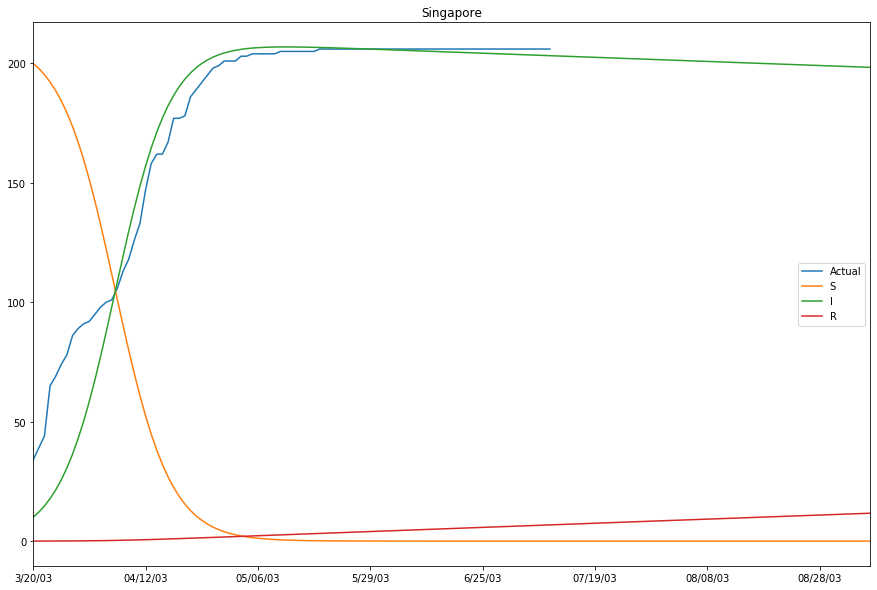

In [8]:
S_0, I_0, R_0 = 200, 10, 0
train('Singapore', loss)

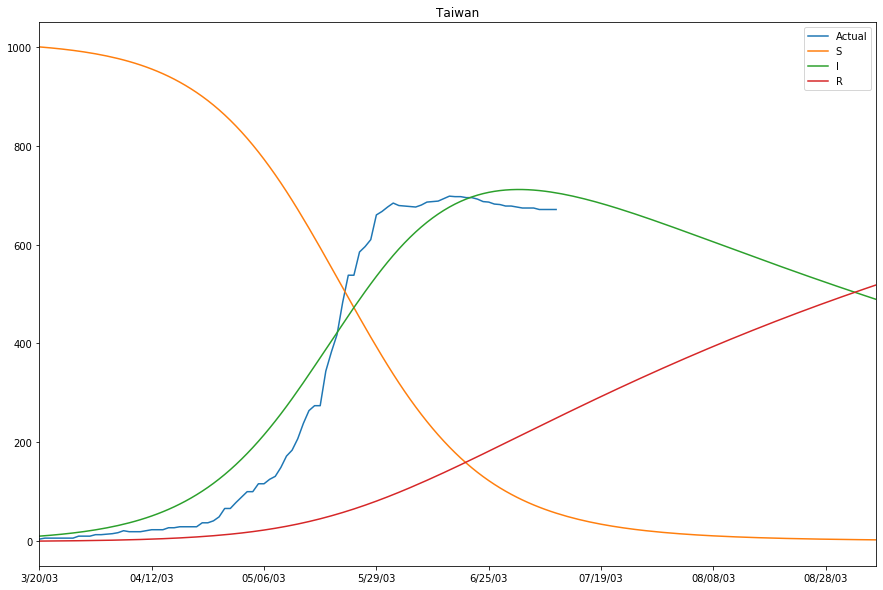

In [9]:
S_0, I_0, R_0 = 1000, 10, 0
train('Taiwan', loss)

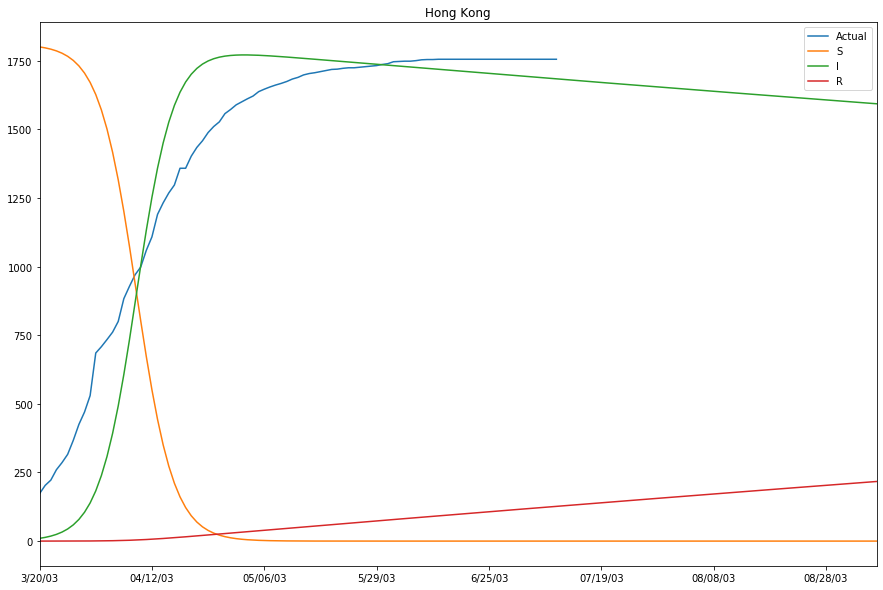

In [10]:
S_0, I_0, R_0 = 1800, 10, 0
train('Hong Kong', loss)